In [1]:
!pip install torchmetrics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler
from tqdm import tqdm

import torch
import torchmetrics
import cv2 as cv
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

In [ ]:
# TRAER LOS DATOS DESDE KAGGLE
import kagglehub

abdallahalidev_plantvillage_dataset_path = kagglehub.dataset_download(
    "abdallahalidev/plantvillage-dataset"
)

print("Data source import complete.")


import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/kaggle/input/plantvillage-dataset/plantvillage dataset/color/Raspberry___healthy/a23af825-fd84-4605-bba9-2560a70c576f___Mary_HL 6371.JPG
/kaggle/input/plantvillage-dataset/plantvillage dataset/color/Raspberry___healthy/3368e77a-9245-4e4f-89ee-41968b060e56___Mary_HL 6251.JPG
/kaggle/input/plantvillage-dataset/plantvillage dataset/color/Raspberry___healthy/4cc1078f-0752-4e3c-bfa0-ed787c1631a4___Mary_HL 6351.JPG
/kaggle/input/plantvillage-dataset/plantvillage dataset/color/Raspberry___healthy/5a43ca3a-6454-4339-b9d9-3ad5e3ca8314___Mary_HL 9147.JPG
/kaggle/input/plantvillage-dataset/plantvillage dataset/color/Raspberry___healthy/d7abcece-f573-4820-8593-7a210f09ba28___Mary_HL 9183.JPG
/kaggle/input/plantvillage-dataset/plantvillage dataset/color/Raspberry___healthy/1e2f76bb-af16-4cc5-9fed-8efa9a68d6a3___Mary_HL 9142.JPG
/kaggle/input/plantvillage-dataset/plantvillage dataset/color/Raspberry___healthy/fa3964a3-4eb8-49c8-b62c

# Tratamiento de datos

In [ ]:
# Species mapping
species_es_map = {
    "Strawberry": "Fresa",
    "Grape": "Uva",
    "Potato": "Papa",
    "Blueberry": "Arándano",
    "Corn_(maize)": "Maíz",
    "Tomato": "Tomate",
    "Peach": "Durazno",
    "Pepper,_bell": "Pimiento",
    "Orange": "Naranja",
    "Cherry_(including_sour)": "Cereza",
    "Apple": "Manzana",
    "Raspberry": "Frambuesa",
    "Squash": "Calabaza",
    "Soybean": "Soja",
}

# Disease mapping
disease_es_map = {
    "Black_rot": "Podredumbre negra",
    "Early_blight": "Tizón temprano",
    "Target_Spot": "Mancha diana",
    "Late_blight": "Tizón tardío",
    "Tomato_mosaic_virus": "Virus del mosaico",
    "Haunglongbing_(Citrus_greening)": "Huanglongbing (enverdecimiento de los cítricos)",
    "Leaf_Mold": "Moho de la hoja",
    "Leaf_blight_(Isariopsis_Leaf_Spot)": "Tizón de la hoja",
    "Powdery_mildew": "Oídio",
    "Cedar_apple_rust": "Roya del manzano y cedro",
    "Bacterial_spot": "Mancha bacteriana",
    "Common_rust_": "Roya común",
    "Esca_(Black_Measles)": "Esca",
    "Tomato_Yellow_Leaf_Curl_Virus": "Virus del rizado amarillo de la hoja",
    "Apple_scab": "Sarna",
    "Northern_Leaf_Blight": "Tizón foliar del norte",
    "Spider_mites Two-spotted_spider_mite": "Ácaros araña de dos manchas",
    "Septoria_leaf_spot": "Mancha foliar por septoria",
    "Cercospora_leaf_spot Gray_leaf_spot": "Mancha foliar por cercospora / mancha foliar gris",
    "Leaf_scorch": "Quemadura de la hoja",
}

In [ ]:
# Directorio en Kaggle
# dataset_path = "plantvillage_dataset/plantvillage dataset/color"
# Directorio para corrida local
dataset_path = "/kaggle/input/plantvillage-dataset/plantvillage dataset/color/"

data = []

# Recorremos carpetas y archivos
if os.path.exists(dataset_path):
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.isdir(folder_path):
            continue
        species, disease = folder.split("___", 1)
        healthy = disease == "healthy"
        disease = None if healthy else disease
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                data.append(
                    {
                        "Format": "color",
                        "Species": species,
                        "Healthy": healthy,
                        "Disease": disease,
                        "FileName": file,
                    }
                )

# Crear DataFrame
df = pd.DataFrame(data)

In [6]:
df

,Format,Species,Healthy,Disease,FileName
0,color,Tomato,False,Late_blight,781e93a9-2059-42de-8075-658033a6abf7___RS_Late...
1,color,Tomato,False,Late_blight,283ff0be-6e5e-4b4e-bf21-639780b77ffc___GHLB2 L...
2,color,Tomato,False,Late_blight,0db85707-41f9-42df-ba3b-842d14f00a68___GHLB2 L...
3,color,Tomato,False,Late_blight,078a999d-6e6f-427e-a1e6-80b4d2df2bae___GHLB2 L...
4,color,Tomato,False,Late_blight,3dcee9ed-43bb-45a9-8cff-641b3dd62179___RS_Late...
...,...,...,...,...,...
54300,color,Corn_(maize),True,None,8cdec02e-6273-452f-8681-1319a74d3698___R.S_HL ...
54301,color,Corn_(maize),True,None,c9c333a8-30ed-4163-adf1-c65379dac7ac___R.S_HL ...
54302,color,Corn_(maize),True,None,85581bfb-0508-4cea-a76c-b929fea867a1___R.S_HL ...
54303,color,Corn_(maize),True,None,0b703646-9307-401b-bd31-ace32353d467___R.S_HL ...


In [ ]:
# Agregar nombre en español para especie
df["Especie"] = df["Species"].map(species_es_map)

# Agregar nombre en español para enfermedad (o 'Sano' si es healthy)
df["Enfermedad"] = df.apply(
    lambda row: (
        "Sano" if row["Healthy"] else disease_es_map.get(row["Disease"], row["Disease"])
    ),
    axis=1,
)

# Duplicar columna "Enfermedad" como "Label", por cuestiones prácticas
df["Label"] = df["Enfermedad"]

# Codificar las etiquetas compuestas como números
df["Label_id"] = df["Label"].astype("category").cat.codes

# Crear el diccionario de mapeo id → etiqueta compuesta
label_map = dict(enumerate(df["Label"].astype("category").cat.categories))

# Número de clases únicas
NUM_CLASSES = len(label_map)

In [8]:
print(f"Número de clases: {NUM_CLASSES}")

Número de clases: 21


In [ ]:
# Semilla reproducible
SEED = 42

# Split 85% train, 15% valid
train_df, valid_df = train_test_split(
    df, test_size=0.15, stratify=df["Label_id"], random_state=SEED
)

In [10]:
len(valid_df)

8146

# Clase

In [ ]:
class PlantVillageDataset(torch.utils.data.Dataset):
    def __init__(self, df, root_dir, format_type="color", transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.format_type = format_type
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        folder = f"{row['Species']}___{'healthy' if row['Healthy'] else row['Disease']}"
        image_path = os.path.join(self.root_dir, folder, row["FileName"])

        image = cv.imread(image_path, cv.IMREAD_COLOR)  # lectura robusta en color
        if image is None:
            raise FileNotFoundError(f"Image not found or unreadable: {image_path}")

        # Asegurar RGB (imread devuelve BGR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # image es numpy array uint8, listo para ToPILImage
        label = torch.tensor(row["Label_id"], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# Dividir dataset para iterar rapido

In [ ]:
USE_SMALL_TRAIN = False  # Usamos el dataset completo porque ya validamos
TRAIN_FRAC = 0.2  # porcentaje de train


def stratified_fraction_indices(y, frac=0.2, seed=1337):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=seed)
    ((idx_small, _),) = sss.split(np.zeros_like(y), y)  # ahora train_size=frac
    return idx_small


base_train_df = train_df
if USE_SMALL_TRAIN:
    idx = stratified_fraction_indices(
        train_df["Label_id"].values, frac=TRAIN_FRAC, seed=1337
    )
    base_train_df = train_df.iloc[idx].reset_index(drop=True)

total_train = len(train_df)
subset_train = len(base_train_df)

print(f"Total imágenes en train: {total_train}")
print(f"Usando en subset: {subset_train} ({subset_train/total_train:.1%} del train)")

Total imágenes en train: 46159
Usando en subset: 46159 (100.0% del train)


# Dataset

In [ ]:
# Normalización estándar ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomResizedCrop((224, 224), scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(
            brightness=0.25, contrast=0.25, saturation=0.25, hue=0.03
        ),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3)),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)


# Transform para validación
val_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

In [ ]:
train_dataset = PlantVillageDataset(
    base_train_df, dataset_path, transform=train_transform
)
valid_dataset = PlantVillageDataset(valid_df, dataset_path, transform=val_transform)

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

data_dict = {
    "train": train_loader,
    "valid": valid_loader,
    "image_width": 224,
    "image_height": 224,
}

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# Class weight

In [ ]:
# Opcion A

counts = (
    base_train_df["Label_id"].value_counts().sort_index().to_numpy(dtype=np.float32)
)
class_weights = torch.tensor(1.0 / (counts + 1e-6), dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(counts)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

In [ ]:
# Opcion B
class FocalLoss(nn.Module):
    """
    Focal Loss para manejar clases muy desbalanceadas.
    Reduce el peso de ejemplos fáciles y se enfoca en ejemplos difíciles.
    """

    def __init__(self, alpha=None, gamma=2.0, reduction="mean", label_smoothing=0.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # tensor de pesos por clase, como en CrossEntropyLoss
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Calcular cross entropy con label smoothing
        ce_loss = F.cross_entropy(
            inputs,
            targets,
            weight=self.alpha,
            reduction="none",
            label_smoothing=self.label_smoothing,
        )

        # Calcular probabilidades
        pt = torch.exp(-ce_loss)

        # Aplicar focal weight: (1-pt)^gamma
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
criterion_focal = FocalLoss(alpha=class_weights, gamma=1.5, label_smoothing=0.05)

# UTIL

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, Any, Optional

In [ ]:
def train(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    data: dict,
    epochs: int,
    scheduler=None,
    tb_writer=None,
    log_interval: int = 10,
    early_stop_patience: int = 5,
    early_stop_metric: str = "valid_loss",
    grad_clip_norm=None,
    use_amp: bool = True,
    best_ckpt_path: str = "mejor_modelo.pth",
):
    from tqdm.auto import tqdm
    import torch

    # Importar AMP de forma compatible
    try:
        # PyTorch >= 2.0
        from torch.amp import autocast, GradScaler

        scaler = GradScaler(enabled=use_amp)

        def autocast_context():
            return autocast(device_type="cuda" if torch.cuda.is_available() else "cpu")

    except ImportError:
        # PyTorch < 2.0
        from torch.cuda.amp import autocast, GradScaler

        autocast_context = lambda: autocast()
        scaler = GradScaler(enabled=use_amp)

    train_loader = data["train"]
    valid_loader = data["valid"]
    device = next(model.parameters()).device
    device_type = (
        "cuda" if torch.cuda.is_available() and device.type == "cuda" else "cpu"
    )

    # Crear métricas
    num_classes = len(set(train_loader.dataset.df["Label_id"]))
    train_metrics = create_metrics(num_classes, device)
    valid_metrics = create_metrics(num_classes, device)

    # Early stopping
    best_score = float("inf") if "loss" in early_stop_metric else 0.0
    patience_counter = 0

    # History expandido
    history = {
        "train_loss": [],
        "valid_loss": [],
        "train_accuracy": [],
        "valid_accuracy": [],
        "train_f1_macro": [],
        "valid_f1_macro": [],
        "train_f1_weighted": [],
        "valid_f1_weighted": [],
        "learning_rate": [],
    }

    for epoch in range(1, epochs + 1):
        # =================
        # TRAINING
        # =================
        model.train()
        reset_metrics(train_metrics)
        running_loss = 0.0

        pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"Epoch {epoch}/{epochs} [Train]",
        )

        for step, (x, y) in pbar:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            if use_amp:
                with autocast_context():
                    logits = model(x)
                    loss = criterion(logits, y)
            else:
                logits = model(x)
                loss = criterion(logits, y)

            # Backward y step
            if scaler.is_enabled():
                scaler.scale(loss).backward()
                if grad_clip_norm is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                if grad_clip_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
                optimizer.step()

            running_loss += loss.item()
            update_metrics(train_metrics, logits, y)

            if step % log_interval == 0:
                avg_loss = running_loss / (step + 1)
                current_acc = train_metrics["accuracy"].compute().item()
                pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{current_acc:.4f}")

        # Compute train metrics
        epoch_train_loss = running_loss / len(train_loader)
        train_scores = compute_metrics(train_metrics)

        # =================
        # VALIDATION
        # =================
        model.eval()
        reset_metrics(valid_metrics)
        val_running_loss = 0.0

        with torch.inference_mode():
            for x, y in valid_loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)

                if use_amp:
                    with autocast_context():
                        logits = model(x)
                        loss = criterion(logits, y)
                else:
                    logits = model(x)
                    loss = criterion(logits, y)

                val_running_loss += loss.item()
                update_metrics(valid_metrics, logits, y)

        epoch_val_loss = val_running_loss / len(valid_loader)
        valid_scores = compute_metrics(valid_metrics)

        # Guardar en history
        history["train_loss"].append(epoch_train_loss)
        history["valid_loss"].append(epoch_val_loss)
        history["train_accuracy"].append(train_scores["accuracy"])
        history["valid_accuracy"].append(valid_scores["accuracy"])
        history["train_f1_macro"].append(train_scores["f1_macro"])
        history["valid_f1_macro"].append(valid_scores["f1_macro"])
        history["train_f1_weighted"].append(train_scores["f1_weighted"])
        history["valid_f1_weighted"].append(valid_scores["f1_weighted"])

        # Learning rate actual
        current_lr = optimizer.param_groups[0]["lr"]
        history["learning_rate"].append(current_lr)

        # Print resultados
        print(f"Epoch {epoch} | LR: {current_lr:.2e}")
        print(
            f"  Train - Loss: {epoch_train_loss:.4f}, Acc: {train_scores['accuracy']:.4f}, "
            f"F1: {train_scores['f1_macro']:.4f}"
        )
        print(
            f"  Valid - Loss: {epoch_val_loss:.4f}, Acc: {valid_scores['accuracy']:.4f}, "
            f"F1: {valid_scores['f1_macro']:.4f}"
        )

        # TensorBoard logging
        if tb_writer:
            # Métricas básicas
            tb_writer["train"].add_scalar("loss", epoch_train_loss, epoch)
            tb_writer["valid"].add_scalar("loss", epoch_val_loss, epoch)
            tb_writer["train"].add_scalar("accuracy", train_scores["accuracy"], epoch)
            tb_writer["valid"].add_scalar("accuracy", valid_scores["accuracy"], epoch)

            # Métricas F1
            tb_writer["train"].add_scalar("f1_macro", train_scores["f1_macro"], epoch)
            tb_writer["valid"].add_scalar("f1_macro", valid_scores["f1_macro"], epoch)
            tb_writer["train"].add_scalar(
                "f1_weighted", train_scores["f1_weighted"], epoch
            )
            tb_writer["valid"].add_scalar(
                "f1_weighted", valid_scores["f1_weighted"], epoch
            )

            # Learning rate
            tb_writer["train"].add_scalar("learning_rate", current_lr, epoch)

            # Flush
            tb_writer["train"].flush()
            tb_writer["valid"].flush()

        # Scheduler step
        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                if early_stop_metric == "valid_loss":
                    scheduler.step(epoch_val_loss)
                elif early_stop_metric == "valid_f1_macro":
                    scheduler.step(valid_scores["f1_macro"])
            else:

                scheduler.step()
        # Early stopping
        if early_stop_metric == "valid_loss":
            current_score = epoch_val_loss
            is_better = current_score < best_score
        elif early_stop_metric == "valid_f1_macro":
            current_score = valid_scores["f1_macro"]
            is_better = current_score > best_score
        else:
            raise ValueError(f"Métrica no soportada: {early_stop_metric}")

        if is_better:
            best_score = current_score
            patience_counter = 0
            torch.save(model.state_dict(), best_ckpt_path)
            print(
                f"✅ Mejor modelo guardado en '{best_ckpt_path}' ({early_stop_metric}={current_score:.4f})"
            )
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"⏹️ Early stopping en epoch {epoch} (paciencia agotada)")
                break

    return history

In [ ]:
def create_metrics(num_classes, device):
    metrics = {
        "accuracy": torchmetrics.classification.MulticlassAccuracy(
            num_classes=num_classes, average="macro"
        ).to(device),
        "f1_macro": torchmetrics.classification.MulticlassF1Score(
            num_classes=num_classes, average="macro"
        ).to(device),
        "f1_weighted": torchmetrics.classification.MulticlassF1Score(
            num_classes=num_classes, average="weighted"
        ).to(device),
        "precision_macro": torchmetrics.classification.MulticlassPrecision(
            num_classes=num_classes, average="macro"
        ).to(device),
        "recall_macro": torchmetrics.classification.MulticlassRecall(
            num_classes=num_classes, average="macro"
        ).to(device),
        # Para análisis per-class (opcional)
        "f1_per_class": torchmetrics.classification.MulticlassF1Score(
            num_classes=num_classes, average="none"
        ).to(device),
    }
    return metrics


def reset_metrics(metrics):
    """Reset todas las métricas."""
    for metric in metrics.values():
        metric.reset()


def update_metrics(metrics, logits, targets):
    """Actualizar todas las métricas."""
    for metric in metrics.values():
        metric.update(logits, targets)


def compute_metrics(metrics):
    """Computar todas las métricas y retornar dict."""
    results = {}
    for name, metric in metrics.items():
        if name == "f1_per_class":
            per_class_scores = metric.compute()
            results[name] = per_class_scores.mean().item()

        else:
            results[name] = metric.compute().item()
    return results

# Model

In [17]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


In [ ]:
import cv2 as cv

cv.setNumThreads(0)  # Esto lo agregue porque me tiraba un bug

In [ ]:
# Info de loaders e imagen
data_dict = {
    "train": train_loader,
    "valid": valid_loader,
    "image_width": 224,
    "image_height": 224,
}

# TensorBoard
writer = {
    "train": SummaryWriter(log_dir="runs/plant_train"),
    "valid": SummaryWriter(log_dir="runs/plant_valid"),
}

# Tecnica entrenar multiple pasos

## Paso A

In [ ]:
import torchmetrics
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

In [ ]:
early_stop_metric = "valid_f1_macro"

In [ ]:
# Congelar backbone para linear probe
for p in model.parameters():
    p.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

# 2) Optimizer (solo la cabeza)
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",  # 'max' porque queremos maximizar F1
    factor=0.5,  # reducir LR a la mitad
    patience=3,  # esperar 3 epochs sin mejora
    verbose=True,
)

# 3) Métrica (macro)
metric = torchmetrics.classification.MulticlassAccuracy(
    num_classes=NUM_CLASSES, average="macro"
).to(device)

history_s1 = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion_focal,
    data=data_dict,
    epochs=10,
    scheduler=scheduler,
    tb_writer=writer,
    early_stop_metric=early_stop_metric,
    best_ckpt_path="best_s1.pth",
)

Epoch 1/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 1 | LR: 1.00e-03
  Train - Loss: 0.3682, Acc: 0.6712, F1: 0.5475
  Valid - Loss: 0.1865, Acc: 0.8283, F1: 0.7185
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.7185)


Epoch 2/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 2 | LR: 1.00e-03
  Train - Loss: 0.2024, Acc: 0.8116, F1: 0.6870
  Valid - Loss: 0.1584, Acc: 0.8602, F1: 0.7608
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.7608)


Epoch 3/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 3 | LR: 1.00e-03
  Train - Loss: 0.1800, Acc: 0.8319, F1: 0.7113
  Valid - Loss: 0.1377, Acc: 0.8905, F1: 0.7976
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.7976)


Epoch 4/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 4 | LR: 1.00e-03
  Train - Loss: 0.1728, Acc: 0.8377, F1: 0.7199
  Valid - Loss: 0.1432, Acc: 0.8862, F1: 0.8060
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.8060)


Epoch 5/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 5 | LR: 1.00e-03
  Train - Loss: 0.1642, Acc: 0.8490, F1: 0.7311
  Valid - Loss: 0.1408, Acc: 0.8807, F1: 0.7901


Epoch 6/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 6 | LR: 1.00e-03
  Train - Loss: 0.1614, Acc: 0.8526, F1: 0.7357
  Valid - Loss: 0.1376, Acc: 0.8813, F1: 0.7697


Epoch 7/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 7 | LR: 1.00e-03
  Train - Loss: 0.1586, Acc: 0.8543, F1: 0.7380
  Valid - Loss: 0.1367, Acc: 0.8924, F1: 0.8140
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.8140)


Epoch 8/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 8 | LR: 1.00e-03
  Train - Loss: 0.1524, Acc: 0.8642, F1: 0.7470
  Valid - Loss: 0.1315, Acc: 0.8989, F1: 0.8182
✅ Mejor modelo guardado en 'best_s1.pth' (valid_f1_macro=0.8182)


Epoch 9/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 9 | LR: 1.00e-03
  Train - Loss: 0.1567, Acc: 0.8572, F1: 0.7419
  Valid - Loss: 0.1334, Acc: 0.8869, F1: 0.7831


Epoch 10/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 10 | LR: 1.00e-03
  Train - Loss: 0.1533, Acc: 0.8627, F1: 0.7459
  Valid - Loss: 0.1362, Acc: 0.8800, F1: 0.7754


## Paso B

In [ ]:
model.load_state_dict(torch.load("/content/best_s1.pth", map_location=device))

<All keys matched successfully>

In [ ]:
# PASO 2
for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.requires_grad = True
for m in model.layer4.modules():  # BN de layer4 en train
    if isinstance(m, nn.BatchNorm2d):
        m.train()
        m.requires_grad_(True)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4
)
history_s2 = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion_focal,
    data=data_dict,
    epochs=10,
    scheduler=scheduler,
    tb_writer=writer,
    early_stop_metric=early_stop_metric,
    best_ckpt_path="best_s2.pth",
)

Epoch 1/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 1 | LR: 3.00e-04
  Train - Loss: 0.1214, Acc: 0.9057, F1: 0.8147
  Valid - Loss: 0.0859, Acc: 0.9519, F1: 0.9083
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9083)


Epoch 2/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 2 | LR: 3.00e-04
  Train - Loss: 0.0756, Acc: 0.9565, F1: 0.9043
  Valid - Loss: 0.0665, Acc: 0.9710, F1: 0.9627
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9627)


Epoch 3/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 3 | LR: 3.00e-04
  Train - Loss: 0.0648, Acc: 0.9677, F1: 0.9300
  Valid - Loss: 0.0635, Acc: 0.9733, F1: 0.9536


Epoch 4/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 4 | LR: 3.00e-04
  Train - Loss: 0.0608, Acc: 0.9710, F1: 0.9377
  Valid - Loss: 0.0541, Acc: 0.9811, F1: 0.9651
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9651)


Epoch 5/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 5 | LR: 3.00e-04
  Train - Loss: 0.0555, Acc: 0.9769, F1: 0.9506
  Valid - Loss: 0.0523, Acc: 0.9790, F1: 0.9633


Epoch 6/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 6 | LR: 3.00e-04
  Train - Loss: 0.0547, Acc: 0.9766, F1: 0.9469
  Valid - Loss: 0.0505, Acc: 0.9827, F1: 0.9725
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9725)


Epoch 7/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 7 | LR: 3.00e-04
  Train - Loss: 0.0505, Acc: 0.9817, F1: 0.9634
  Valid - Loss: 0.0487, Acc: 0.9855, F1: 0.9774
✅ Mejor modelo guardado en 'best_s2.pth' (valid_f1_macro=0.9774)


Epoch 8/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 8 | LR: 3.00e-04
  Train - Loss: 0.0483, Acc: 0.9835, F1: 0.9660
  Valid - Loss: 0.0501, Acc: 0.9840, F1: 0.9696


Epoch 9/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 9 | LR: 3.00e-04
  Train - Loss: 0.0483, Acc: 0.9841, F1: 0.9682
  Valid - Loss: 0.0479, Acc: 0.9857, F1: 0.9759


Epoch 10/10 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 10 | LR: 3.00e-04
  Train - Loss: 0.0481, Acc: 0.9832, F1: 0.9650
  Valid - Loss: 0.0472, Acc: 0.9852, F1: 0.9693


### Paso C

In [ ]:
model.load_state_dict(torch.load("best_s2.pth", map_location=device))

for p in model.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
history_s3 = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion_focal,
    data=data_dict,
    epochs=12,
    scheduler=scheduler,
    tb_writer=writer,
    early_stop_metric=early_stop_metric,
    best_ckpt_path="best_s3.pth",
)

Epoch 1/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 1 | LR: 1.00e-04
  Train - Loss: 0.0496, Acc: 0.9817, F1: 0.9650
  Valid - Loss: 0.0513, Acc: 0.9818, F1: 0.9746
✅ Mejor modelo guardado en 'best_s3.pth' (valid_f1_macro=0.9746)


Epoch 2/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 2 | LR: 1.00e-04
  Train - Loss: 0.0455, Acc: 0.9863, F1: 0.9745
  Valid - Loss: 0.0529, Acc: 0.9773, F1: 0.9744


Epoch 3/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 3 | LR: 1.00e-04
  Train - Loss: 0.0426, Acc: 0.9899, F1: 0.9794
  Valid - Loss: 0.0449, Acc: 0.9895, F1: 0.9869
✅ Mejor modelo guardado en 'best_s3.pth' (valid_f1_macro=0.9869)


Epoch 4/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 4 | LR: 1.00e-04
  Train - Loss: 0.0415, Acc: 0.9908, F1: 0.9824
  Valid - Loss: 0.0447, Acc: 0.9893, F1: 0.9865


Epoch 5/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 5 | LR: 1.00e-04
  Train - Loss: 0.0408, Acc: 0.9917, F1: 0.9837
  Valid - Loss: 0.0440, Acc: 0.9870, F1: 0.9855


Epoch 6/12 [Train]:   0%|          | 0/361 [00:00<?, ?it/s]

# Validacion

In [18]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)
state = torch.load("/content/best_s3_4.pth", map_location=device)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
@torch.no_grad()
def eval_metrics(model, valid_loader, device, label_map=None):
    model.eval()
    y_true, y_pred = [], []

    for x, y in valid_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        y_true.append(y.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Accuracy global
    acc_global = accuracy_score(y_true, y_pred)

    # Identificar el ID de la clase 'Sano'
    sano_id = None
    if label_map is not None:
        for k, v in label_map.items():
            if str(v).lower() == "sano":
                sano_id = int(k)
                break

    if sano_id is None:
        print("Available labels in label_map:", label_map)
        raise ValueError("No se pudo encontrar la clase 'Sano' en label_map")

    print(f"ID de la clase 'Sano': {sano_id}")

    # Métricas binarias: Sano vs Enfermo
    y_true_sano = (y_true == sano_id).astype(int)
    y_pred_sano = (y_pred == sano_id).astype(int)
    recall_sano = recall_score(y_true_sano, y_pred_sano, zero_division=0)
    f1_sano = f1_score(y_true_sano, y_pred_sano, zero_division=0)

    # Métricas para enfermedades (todo lo que NO es 'Sano')
    y_true_enf = (y_true != sano_id).astype(int)
    y_pred_enf = (y_pred != sano_id).astype(int)
    recall_enf = recall_score(y_true_enf, y_pred_enf, zero_division=0)
    f1_enf = f1_score(y_true_enf, y_pred_enf, zero_division=0)

    return acc_global, recall_sano, f1_sano, recall_enf, f1_enf

In [ ]:
acc, r_sano, f1_sano, r_enf, f1_enf = eval_metrics(
    model, valid_loader, device, label_map=label_map
)

print(f"Accuracy global: {acc:.4f}")
print(f"Recall clase 'Sano': {r_sano:.4f}")
print(f"F1-score clase 'Sano': {f1_sano:.4f}")
print(f"Recall enfermedades (combinadas): {r_enf:.4f}")
print(f"F1-score enfermedades (combinadas): {f1_enf:.4f}")

ID de la clase 'Sano': 12
Accuracy global: 0.9942
Recall clase 'Sano': 0.9947
F1-score clase 'Sano': 0.9971
Recall enfermedades (combinadas): 0.9998
F1-score enfermedades (combinadas): 0.9989


In [ ]:
acc, r_sano, f1_sano, r_enf, f1_enf = eval_metrics(
    model, valid_loader, device, label_map=label_map
)

print(f"Accuracy global: {acc:.4f}")
print(f"Recall clase 'Sano': {r_sano:.4f}")
print(f"F1-score clase 'Sano': {f1_sano:.4f}")
print(f"Recall enfermedades (combinadas): {r_enf:.4f}")
print(f"F1-score enfermedades (combinadas): {f1_enf:.4f}")

ID de la clase 'Sano': 12
Accuracy global: 0.9806
Recall clase 'Sano': 0.9576
F1-score clase 'Sano': 0.9783
Recall enfermedades (combinadas): 1.0000
F1-score enfermedades (combinadas): 0.9919


In [ ]:
from sklearn.metrics import precision_recall_fscore_support


@torch.no_grad()
def metrics_sano_enfermo(model, loader, device, label_map):
    sano_id = next(k for k, v in label_map.items() if str(v).lower() == "sano")
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(1).cpu().numpy()
        y_true.append(yb.numpy())
        y_pred.append(pred)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # 3) binarizar (Sano=1 / Enfermo=0) para métricas por "Sanas"
    yt_sano = (y_true == sano_id).astype(int)
    yp_sano = (y_pred == sano_id).astype(int)
    P_sano, R_sano, F1_sano, _ = precision_recall_fscore_support(
        yt_sano, yp_sano, average="binary", zero_division=0
    )

    # 4) binarizar (Enfermo=1 / Sano=0) para métricas por "Enfermas"
    yt_enf = (y_true != sano_id).astype(int)
    yp_enf = (y_pred != sano_id).astype(int)
    P_enf, R_enf, F1_enf, _ = precision_recall_fscore_support(
        yt_enf, yp_enf, average="binary", zero_division=0
    )

    # 5) imprimir tabla
    print("\nClass Weights: equilibrando el aprendizaje\n")
    print(f"{'':12s} {'Precision':>10s} {'Recall':>10s} {'F1-score':>10s}")
    print("-" * 46)
    print(f"{'Sanas':12s} {P_sano:10.4f} {R_sano:10.4f} {F1_sano:10.4f}")
    print(f"{'Enfermas':12s} {P_enf:10.4f} {R_enf:10.4f} {F1_enf:10.4f}")

    return {
        "Sanas": {"precision": P_sano, "recall": R_sano, "f1": F1_sano},
        "Enfermas": {"precision": P_enf, "recall": R_enf, "f1": F1_enf},
    }

In [22]:
res = metrics_sano_enfermo(model, valid_loader, device, label_map)


Class Weights: equilibrando el aprendizaje

              Precision     Recall   F1-score
----------------------------------------------
Sanas            0.9996     0.9947     0.9971
Enfermas         0.9980     0.9998     0.9989


In [ ]:
@torch.no_grad()
def preds_targets(model, loader, device):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        p = model(x).argmax(1)
        ys.append(y.cpu().numpy())
        ps.append(p.cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)


y_true, y_pred = preds_targets(model, valid_loader, device)
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

Confusion matrix shape: (21, 21)


In [24]:
train_df

,Format,Species,Healthy,Disease,FileName,Especie,Enfermedad,Label,Label_id
44014,color,Grape,False,Black_rot,0a06c482-c94a-44d8-a895-be6fe17b8c06___FAM_B.R...,Uva,Podredumbre negra,Podredumbre negra,8
11894,color,Soybean,True,None,72ae9007-eec9-4386-9090-d1c52235c8d5___RS_HL 3...,Soja,Sano,Sano,12
43904,color,Grape,False,Black_rot,8c6c9f8b-5f1a-4f35-8481-a9d2cb8d52c6___FAM_B.R...,Uva,Podredumbre negra,Podredumbre negra,8
8524,color,Orange,False,Haunglongbing_(Citrus_greening),12723c6c-3ed4-456f-a5c4-5f88a8689cac___CREC_HL...,Naranja,Huanglongbing (enverdecimiento de los cítricos),Huanglongbing (enverdecimiento de los cítricos),1
28025,color,Tomato,False,Tomato_Yellow_Leaf_Curl_Virus,aa4a0712-00cb-42bd-8ffa-bfc952f10582___YLCV_NR...,Tomate,Virus del rizado amarillo de la hoja,Virus del rizado amarillo de la hoja,19
...,...,...,...,...,...,...,...,...,...
39044,color,Grape,False,Leaf_blight_(Isariopsis_Leaf_Spot),7840bdb2-d326-4fe4-8afb-968636c209b7___FAM_L.B...,Uva,Tizón de la hoja,Tizón de la hoja,14
23364,color,Tomato,False,Tomato_Yellow_Leaf_Curl_Virus,1d89e540-4dc1-442f-a5d8-b44bb5100bda___UF.GRC_...,Tomate,Virus del rizado amarillo de la hoja,Virus del rizado amarillo de la hoja,19
42292,color,Apple,True,None,c7ede8ae-237e-4228-b635-96d3b6a0bebe___RS_HL 7...,Manzana,Sano,Sano,12
23610,color,Tomato,False,Tomato_Yellow_Leaf_Curl_Virus,81540030-4132-4b95-803e-eef54ed6a842___YLCV_NR...,Tomate,Virus del rizado amarillo de la hoja,Virus del rizado amarillo de la hoja,19


In [ ]:
class_names = sorted(train_df["Label"].unique().tolist())

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                                                   precision    recall  f1-score   support

                                             Esca       1.00      1.00      1.00       207
  Huanglongbing (enverdecimiento de los cítricos)       1.00      1.00      1.00       826
                                Mancha bacteriana       1.00      0.99      0.99       813
                                     Mancha diana       0.94      1.00      0.97       211
Mancha foliar por cercospora / mancha foliar gris       0.90      0.96      0.93        77
                       Mancha foliar por septoria       1.00      0.99      0.99       266
                                  Moho de la hoja       1.00      1.00      1.00       143
                                            Oídio       1.00      1.00      1.00       433
                                Podredumbre negra       1.00      1.00      1.00       270
                             Quemadura de la hoja       1.00      1.00      1.00       16

In [ ]:
def plot_confusion_matrix_blue(
    y_true, y_pred, class_names, normalize=False, title="Matriz de Confusión"
):
    labels = list(range(len(class_names)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    cm_display = cm.astype(float)
    if normalize:
        row_sums = cm_display.sum(axis=1, keepdims=True).clip(min=1.0)
        cm_display = cm_display / row_sums

    fig, ax = plt.subplots(figsize=(11, 11))

    im = ax.imshow(cm_display, interpolation="nearest", cmap=plt.cm.Blues)

    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Etiqueta real")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    fmt = ".2f" if normalize else "d"
    thresh = cm_display.max() / 2.0 if cm_display.size else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm_display[i, j]
            if normalize:
                text = f"{val:{fmt}}"
            else:
                if cm[i, j] == 0:
                    continue
                text = f"{cm[i, j]:{fmt}}"
            ax.text(
                j,
                i,
                text,
                ha="center",
                va="center",
                fontsize=8,
                color="white" if val > thresh else "black",
            )

    plt.tight_layout()
    plt.show()

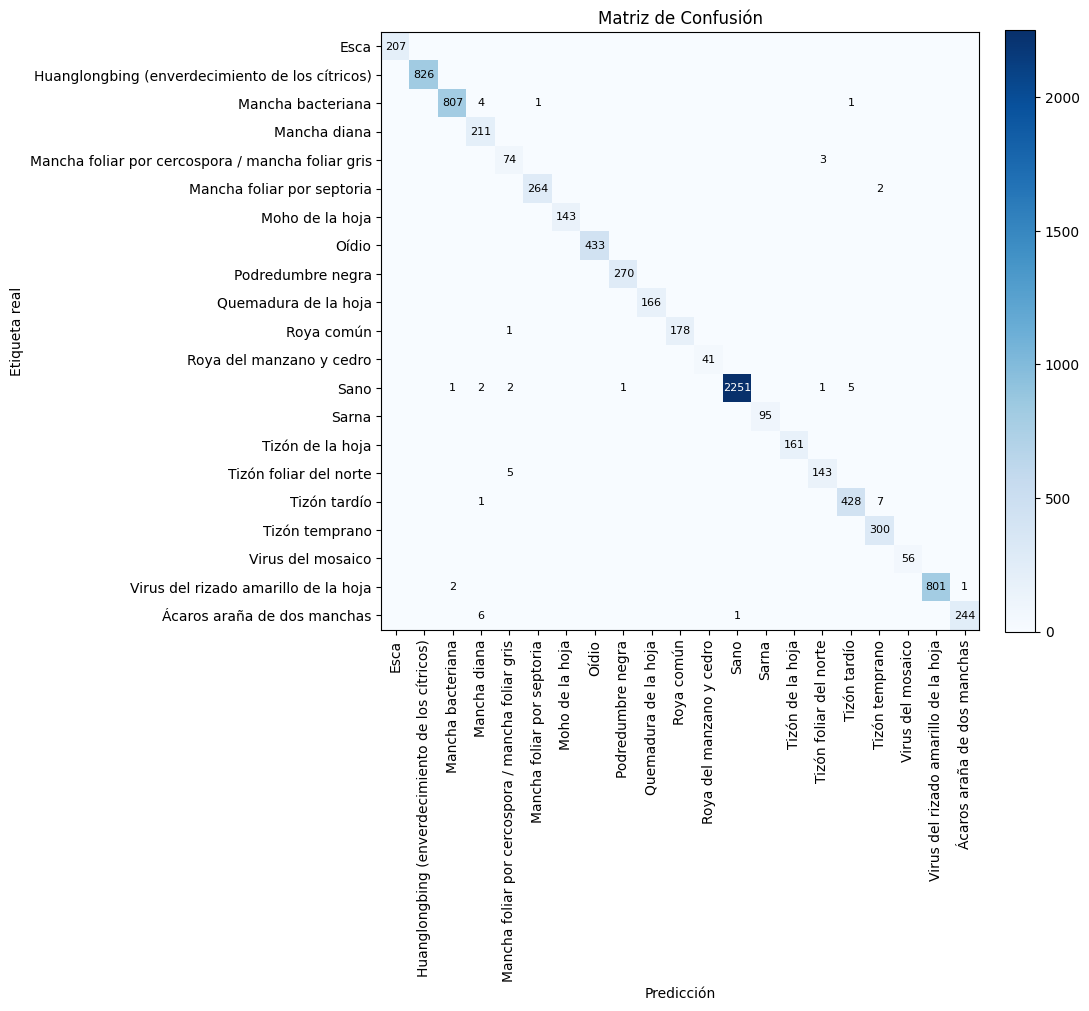

In [29]:
plot_confusion_matrix_blue(y_true, y_pred, class_names, normalize=False)